In [1]:
import numpy as np
import pandas as pd

import time
from datetime import datetime

import gensim
import matplotlib.pyplot as plt

import en_nlp_utils
import model_evaluation_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-26 23:04:42.256526


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

In [4]:
# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

# Remove rows when "review_cleaned_v2" is NULL
df_review = df_review.dropna(subset=["review_cleaned_v2"]).reset_index(drop=True)

df_review:
source                     0
hotel_id                   0
hotel_name                 0
country                    0
group_name                 0
room_type                  0
stay_length                0
stay_date                  0
review_score               0
review_score_category      0
sentiment                  0
review_date                0
review_title               1
review                     0
review_cleaned_v1          0
review_cleaned_v2        229
dtype: int64
Total rows in df_review: 39831 



## 1) Applying Stratified Sampling

In [5]:
# Function for stratified sampling
def stratified_sample(df, stratify_col, frac):
    return df.groupby(stratify_col, group_keys=False).apply(lambda x: x.sample(frac=frac))

# Convert "stay_date" and "review_date" columns as datetime data type
df_review["stay_date"] = pd.to_datetime(df_review["stay_date"], format="%d/%m/%Y")

# Stratified sampling based on year and sentiment
frac = 0.30  # Sampling ratio
sampled_2022 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2022], "sentiment", frac)
sampled_2023 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2023], "sentiment", frac)
sampled_2024 = stratified_sample(df_review[df_review["stay_date"].dt.year == 2024], "sentiment", frac)

# Merge the sampled data
sampled_data = pd.concat([sampled_2022, sampled_2023, sampled_2024])

In [6]:
# Count number of reviews based on year and sentiment
sampled_sentiment_count = sampled_data.groupby([sampled_data["sentiment"], sampled_data["stay_date"].dt.year]).size().reset_index(name="count")
sampled_sentiment_count2 = sampled_sentiment_count.pivot_table(index="stay_date", columns="sentiment", values="count", 
                                               aggfunc="sum", margins=True, margins_name="Total")
sampled_sentiment_count2.columns.name = None
sampled_sentiment_count2

,negative,positive,Total
stay_date,,,
2022,506,1655,2161
2023,1604,6372,7976
2024,329,1413,1742
Total,2439,9440,11879


## 2) Topic Modeling

### a) Helper functions

In [7]:
# Function to generate bow corpus
def generate_bow_corpus(df, target_text):
    
    documents = [en_nlp_utils.tokenize_sentence_to_words(cleaned_review) for cleaned_review in df[target_text]]
    
    bigram = gensim.models.Phrases(documents, min_count=20, threshold=20, delimiter="_") # higher threshold fewer phrases.
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    corpus_bigrams = [bigram_model[doc] for doc in documents]
    dictionary = gensim.corpora.Dictionary(corpus_bigrams)
    dictionary.filter_extremes(no_below=20, no_above=0.6)
    bow_corpus = [dictionary.doc2bow(text) for text in corpus_bigrams]
    
    return bow_corpus, corpus_bigrams, dictionary


# Function to calculate all models' coherence scores
def topic_model_coherence_plot(df, df_name, target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT):
    
    overall_coherence_df = pd.DataFrame() # Store each model's coherence scores
    model_topic_info = [] # Store each model's topic information
    
    bow_corpus, corpus_bigrams, dictionary = generate_bow_corpus(df, target_text)
    model_count = 0
    
    for MODEL_NAME in MODEL_NAMES:
        models, coherence_scores = en_nlp_utils.topic_model_coherence_generator(model_name=MODEL_NAME,
                                                                                corpus=bow_corpus,
                                                                                texts=corpus_bigrams,
                                                                                dictionary=dictionary,
                                                                                start_topic_count=START_TOPIC_COUNT,
                                                                                end_topic_count=END_TOPIC_COUNT,
                                                                                step=1,
                                                                                cpus=-1,
                                                                                print_topics=True)

        coherence_df = pd.DataFrame({"Model Name": MODEL_NAME, 
                                     "Number of Topics": range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1), 
                                     "Coherence Score": np.round(coherence_scores, 6),
                                     "df_name": df_name})
        coherence_df.sort_values(by=["Coherence Score"], ascending=False)
        print(coherence_df)
        
        overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0)
        
        model_topics = []
        for model in models:
            num_topics = model.num_topics
            topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=10)] for n in range(num_topics)]
            
            # Determine the number of columns dynamically
            num_terms_per_topic = max(len(topic) for topic in topics)
            
            # Create a DataFrame for topics with dynamic columns and names
            topics_df = pd.DataFrame([[term if len(topic) > i else "" for i, (term, wt) in enumerate(topic)]
                                      for topic in topics],
                                     columns=[f"Term{i+1}" for i in range(num_terms_per_topic)],
                                     index=[f"Topic {t+1}" for t in range(num_topics)]).T
            
            model_topic_info.append({
                "Model Name": MODEL_NAME,
                "Number of Topics": num_topics,
                "Topics": topics_df.to_dict(orient="list"),  # Convert DataFrame to dictionary
                "df_name": df_name
            })
        
        x_ax = range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1)
        y_ax = coherence_scores
        plt.figure(num=model_count, figsize=(15, 12))
        plt.plot(x_ax, y_ax, c="r")
        plt.axhline(y=0.3, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.4, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.5, c="k", linestyle="--", linewidth=2)
        plt.rcParams["figure.facecolor"] = "white"
        xl = plt.xlabel("Number of Topics")
        yl = plt.ylabel("Coherence Score")

        model_count += 1

    plt.show()
    return overall_coherence_df, model_topic_info


# Function to print best model's topics
def print_best_model_topics(overall_coherence_best_df, model_topic_info_list):
    
    for index, row in overall_coherence_best_df.iterrows():
        model_name = row["Model Name"]
        num_topics = row["Number of Topics"]
        df_name = row["df_name"]
        
        print(f"\nDF NAME: {df_name}\nMODEL: {model_name} - NUMBER OF TOPICS: {num_topics}")
       
        # Find the corresponding model_topic_info
        for model_topic_info in model_topic_info_list:
            for model_info in model_topic_info:
                if (model_info["Model Name"] == model_name and
                    model_info["Number of Topics"] == num_topics and
                    model_info["df_name"] == df_name):
                    
                    topics = model_info["Topics"]
                    for topic_num, terms in topics.items():
                        print(f"\n{topic_num}: {', '.join(terms)}")
                        
                    print("\n----------\n")
                    break

### b) Topic Modeling

In [8]:
# Filter positive and negative reviews and save into different dataframe
df_pos = sampled_data[sampled_data["sentiment"] == "positive"].reset_index(drop=True)
df_neg = sampled_data[sampled_data["sentiment"] == "negative"].reset_index(drop=True)

In [9]:
MODEL_NAMES = ["LSI", "LDA"]
START_TOPIC_COUNT = 2
END_TOPIC_COUNT = 10

df_sets = [df_pos, df_neg]
df_names = ["df_pos", "df_neg"]


DF NAME: df_pos



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▏                                                                         | 1/9 [02:54<23:14, 174.31s/it]

Topic #1:
0.411*"good" + 0.370*"staff" + 0.284*"clean" + 0.168*"great" + 0.159*"also" + 0.151*"check" + 0.146*"nice" + 0.144*"friendly" + 0.133*"small" + 0.132*"bed" + 0.115*"meet" + 0.113*"need" + 0.109*"helpful" + 0.102*"well" + 0.100*"breakfast" + 0.100*"near" + 0.094*"food" + 0.091*"area" + 0.087*"overall" + 0.086*"like"

Topic #2:
-0.853*"good" + 0.287*"staff" + 0.197*"check" + 0.148*"great" + 0.100*"also" + 0.096*"friendly" + 0.074*"book" + 0.072*"clean" + 0.069*"helpful" + 0.065*"ask" + 0.056*"tell" + 0.054*"say" + 0.051*"guest" + 0.050*"give" + 0.049*"nice" + 0.049*"make" + 0.046*"need" + 0.045*"reception" + 0.043*"pm" + 0.042*"take"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▍                                                                | 2/9 [05:46<20:12, 173.25s/it]

Topic #1:
0.409*"good" + 0.374*"staff" + 0.286*"clean" + 0.170*"great" + 0.158*"also" + 0.149*"check" + 0.147*"nice" + 0.146*"friendly" + 0.133*"small" + 0.131*"bed" + 0.116*"meet" + 0.112*"need" + 0.110*"helpful" + 0.102*"well" + 0.100*"breakfast" + 0.100*"near" + 0.094*"food" + 0.091*"area" + 0.087*"overall" + 0.086*"like"

Topic #2:
-0.860*"good" + 0.323*"staff" + 0.178*"great" + 0.139*"check" + 0.119*"friendly" + 0.097*"clean" + 0.086*"also" + 0.083*"helpful" + 0.065*"nice" + 0.052*"book" + 0.047*"make" + 0.047*"ask" + 0.042*"guest" + 0.037*"need" + 0.037*"give" + 0.036*"could" + 0.035*"say" + 0.034*"tell" + 0.033*"well" + 0.033*"take"

Topic #3:
0.543*"staff" + -0.326*"check" + 0.273*"friendly" + -0.176*"book" + 0.167*"helpful" + -0.166*"also" + 0.154*"great" + -0.145*"bed" + 0.133*"clean" + -0.129*"need" + 0.124*"good" + -0.099*"ask" + -0.099*"want" + -0.096*"shower" + -0.095*"give" + -0.093*"say" + -0.093*"door" + -0.092*"tell" + 0.092*"nice" + -0.088*"pm"

---------------------

 33%|███████████████████████████▋                                                       | 3/9 [08:35<17:05, 170.98s/it]

Topic #1:
0.409*"good" + 0.375*"staff" + 0.286*"clean" + 0.170*"great" + 0.158*"also" + 0.149*"check" + 0.147*"nice" + 0.147*"friendly" + 0.133*"small" + 0.131*"bed" + 0.115*"meet" + 0.112*"need" + 0.110*"helpful" + 0.102*"well" + 0.100*"breakfast" + 0.100*"near" + 0.094*"food" + 0.091*"area" + 0.087*"overall" + 0.086*"like"

Topic #2:
-0.867*"good" + 0.300*"staff" + 0.182*"great" + 0.134*"check" + 0.110*"friendly" + 0.102*"clean" + 0.091*"also" + 0.077*"helpful" + 0.064*"nice" + 0.054*"book" + 0.048*"make" + 0.046*"ask" + 0.041*"need" + 0.041*"guest" + 0.039*"give" + 0.037*"could" + 0.036*"say" + 0.035*"well" + 0.034*"bed" + 0.034*"take"

Topic #3:
0.655*"staff" + 0.295*"friendly" + 0.174*"helpful" + -0.173*"also" + -0.170*"bed" + 0.162*"good" + -0.152*"check" + -0.141*"small" + 0.136*"great" + -0.120*"book" + -0.114*"need" + -0.101*"bathroom" + -0.100*"shower" + -0.080*"clean" + -0.080*"use" + -0.080*"toilet" + -0.078*"well" + -0.076*"give" + -0.072*"water" + -0.071*"door"

Topic #4:

 44%|████████████████████████████████████▉                                              | 4/9 [11:35<14:33, 174.77s/it]

Topic #1:
0.408*"good" + 0.374*"staff" + 0.286*"clean" + 0.168*"great" + 0.158*"also" + 0.149*"check" + 0.148*"nice" + 0.147*"friendly" + 0.133*"small" + 0.132*"bed" + 0.116*"meet" + 0.112*"need" + 0.110*"helpful" + 0.102*"well" + 0.100*"breakfast" + 0.100*"near" + 0.094*"food" + 0.091*"area" + 0.087*"overall" + 0.086*"like"

Topic #2:
-0.867*"good" + 0.304*"staff" + 0.162*"great" + 0.142*"check" + 0.110*"friendly" + 0.103*"clean" + 0.088*"also" + 0.076*"helpful" + 0.064*"nice" + 0.057*"book" + 0.049*"make" + 0.049*"ask" + 0.043*"guest" + 0.041*"give" + 0.040*"need" + 0.038*"could" + 0.037*"say" + 0.036*"bed" + 0.036*"well" + 0.036*"tell"

Topic #3:
0.655*"staff" + 0.291*"friendly" + 0.173*"helpful" + -0.168*"also" + -0.167*"bed" + 0.161*"good" + -0.155*"check" + -0.151*"small" + 0.131*"great" + -0.120*"book" + -0.118*"need" + -0.102*"shower" + -0.098*"bathroom" + -0.086*"well" + -0.086*"toilet" + -0.082*"give" + -0.082*"use" + -0.077*"like" + -0.073*"meet" + -0.073*"near"

Topic #4:
0

 56%|██████████████████████████████████████████████                                     | 5/9 [14:35<11:46, 176.61s/it]

Topic #1:
0.408*"good" + 0.374*"staff" + 0.286*"clean" + 0.168*"great" + 0.158*"also" + 0.149*"check" + 0.148*"nice" + 0.147*"friendly" + 0.133*"small" + 0.132*"bed" + 0.115*"meet" + 0.112*"need" + 0.110*"helpful" + 0.102*"well" + 0.100*"breakfast" + 0.100*"near" + 0.094*"food" + 0.091*"area" + 0.087*"overall" + 0.086*"like"

Topic #2:
-0.867*"good" + 0.311*"staff" + 0.148*"great" + 0.139*"check" + 0.112*"friendly" + 0.092*"also" + 0.084*"clean" + 0.078*"helpful" + 0.068*"nice" + 0.058*"book" + 0.049*"make" + 0.048*"ask" + 0.044*"guest" + 0.042*"give" + 0.040*"need" + 0.038*"could" + 0.038*"say" + 0.036*"well" + 0.036*"tell" + 0.036*"take"

Topic #3:
0.658*"staff" + 0.294*"friendly" + 0.175*"helpful" + -0.167*"bed" + -0.164*"also" + 0.160*"good" + -0.157*"check" + -0.147*"small" + -0.119*"need" + -0.118*"book" + 0.106*"great" + -0.104*"shower" + -0.099*"bathroom" + -0.090*"well" + -0.086*"toilet" + -0.082*"use" + -0.081*"give" + -0.077*"like" + -0.071*"door" + -0.070*"meet"

Topic #4:


 67%|███████████████████████████████████████████████████████▎                           | 6/9 [17:43<09:01, 180.47s/it]

Topic #1:
0.408*"good" + 0.374*"staff" + 0.286*"clean" + 0.169*"great" + 0.158*"also" + 0.149*"check" + 0.147*"nice" + 0.147*"friendly" + 0.133*"small" + 0.132*"bed" + 0.115*"meet" + 0.112*"need" + 0.110*"helpful" + 0.102*"well" + 0.100*"breakfast" + 0.099*"near" + 0.094*"food" + 0.091*"area" + 0.087*"overall" + 0.086*"like"

Topic #2:
-0.867*"good" + 0.308*"staff" + 0.151*"great" + 0.144*"check" + 0.110*"friendly" + 0.091*"also" + 0.088*"clean" + 0.077*"helpful" + 0.063*"nice" + 0.061*"book" + 0.049*"make" + 0.049*"ask" + 0.044*"guest" + 0.043*"give" + 0.041*"need" + 0.038*"say" + 0.038*"could" + 0.036*"well" + 0.036*"tell" + 0.035*"bed"

Topic #3:
0.661*"staff" + 0.295*"friendly" + 0.176*"helpful" + -0.168*"check" + -0.164*"also" + -0.163*"bed" + 0.155*"good" + -0.142*"small" + -0.123*"book" + -0.120*"need" + -0.101*"shower" + 0.099*"great" + -0.099*"bathroom" + -0.089*"well" + -0.085*"toilet" + -0.082*"give" + -0.082*"use" + -0.075*"like" + -0.069*"water" + -0.068*"door"

Topic #4:


 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [20:53<06:07, 183.59s/it]

Topic #1:
0.408*"good" + 0.374*"staff" + 0.286*"clean" + 0.170*"great" + 0.158*"also" + 0.150*"check" + 0.147*"nice" + 0.146*"friendly" + 0.133*"small" + 0.132*"bed" + 0.115*"meet" + 0.112*"need" + 0.110*"helpful" + 0.102*"well" + 0.100*"breakfast" + 0.100*"near" + 0.094*"food" + 0.091*"area" + 0.087*"overall" + 0.086*"like"

Topic #2:
-0.867*"good" + 0.306*"staff" + 0.163*"great" + 0.143*"check" + 0.110*"friendly" + 0.090*"also" + 0.085*"clean" + 0.077*"helpful" + 0.058*"book" + 0.057*"nice" + 0.049*"make" + 0.048*"ask" + 0.043*"guest" + 0.041*"give" + 0.041*"need" + 0.038*"say" + 0.038*"could" + 0.037*"bed" + 0.036*"well" + 0.036*"tell"

Topic #3:
0.661*"staff" + 0.295*"friendly" + 0.176*"helpful" + -0.173*"check" + -0.166*"also" + -0.162*"bed" + 0.154*"good" + -0.138*"small" + -0.126*"book" + -0.119*"need" + 0.101*"great" + -0.100*"shower" + -0.098*"bathroom" + -0.088*"well" + -0.084*"toilet" + -0.082*"give" + -0.081*"use" + -0.074*"like" + -0.070*"meet" + -0.069*"water"

Topic #4:


 89%|█████████████████████████████████████████████████████████████████████████▊         | 8/9 [24:20<03:10, 190.88s/it]

Topic #1:
0.408*"good" + 0.374*"staff" + 0.286*"clean" + 0.170*"great" + 0.158*"also" + 0.150*"check" + 0.147*"nice" + 0.146*"friendly" + 0.133*"small" + 0.132*"bed" + 0.115*"meet" + 0.112*"need" + 0.110*"helpful" + 0.102*"well" + 0.100*"breakfast" + 0.100*"near" + 0.094*"food" + 0.091*"area" + 0.087*"overall" + 0.086*"like"

Topic #2:
-0.868*"good" + 0.305*"staff" + 0.160*"great" + 0.143*"check" + 0.109*"friendly" + 0.089*"also" + 0.086*"clean" + 0.077*"helpful" + 0.059*"book" + 0.058*"nice" + 0.049*"ask" + 0.048*"make" + 0.043*"guest" + 0.042*"need" + 0.041*"give" + 0.039*"bed" + 0.038*"could" + 0.037*"say" + 0.036*"tell" + 0.035*"take"

Topic #3:
0.660*"staff" + 0.295*"friendly" + 0.175*"helpful" + -0.169*"also" + -0.166*"check" + -0.163*"bed" + 0.154*"good" + -0.144*"small" + -0.125*"book" + -0.118*"need" + -0.101*"shower" + 0.101*"great" + -0.099*"bathroom" + -0.085*"toilet" + -0.084*"well" + -0.082*"use" + -0.081*"give" + -0.075*"like" + -0.073*"meet" + -0.072*"water"

Topic #4:


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [27:24<00:00, 182.71s/it]


Topic #1:
0.408*"good" + 0.374*"staff" + 0.286*"clean" + 0.170*"great" + 0.158*"also" + 0.150*"check" + 0.148*"nice" + 0.146*"friendly" + 0.133*"small" + 0.132*"bed" + 0.115*"meet" + 0.112*"need" + 0.110*"helpful" + 0.102*"well" + 0.100*"near" + 0.100*"breakfast" + 0.094*"food" + 0.091*"area" + 0.087*"overall" + 0.086*"like"

Topic #2:
-0.868*"good" + 0.305*"staff" + 0.160*"great" + 0.144*"check" + 0.109*"friendly" + 0.090*"also" + 0.088*"clean" + 0.077*"helpful" + 0.059*"nice" + 0.058*"book" + 0.049*"ask" + 0.048*"make" + 0.043*"guest" + 0.042*"need" + 0.041*"give" + 0.038*"bed" + 0.037*"could" + 0.037*"say" + 0.035*"well" + 0.035*"take"

Topic #3:
0.662*"staff" + 0.296*"friendly" + 0.177*"helpful" + -0.169*"also" + -0.166*"bed" + -0.165*"check" + 0.154*"good" + -0.143*"small" + -0.126*"book" + -0.116*"need" + -0.100*"shower" + -0.099*"bathroom" + 0.097*"great" + -0.085*"toilet" + -0.084*"well" + -0.082*"use" + -0.081*"give" + -0.075*"like" + -0.072*"water" + -0.069*"meet"

Topic #4:


  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:07<00:58,  7.37s/it]

Topic #1:
0.016*"great" + 0.013*"staff" + 0.012*"good" + 0.011*"need" + 0.011*"also" + 0.010*"clean" + 0.010*"nice" + 0.007*"area" + 0.007*"close" + 0.007*"bed" + 0.007*"use" + 0.006*"well" + 0.006*"like" + 0.006*"provide" + 0.006*"check" + 0.006*"shower" + 0.006*"food" + 0.005*"make" + 0.005*"breakfast" + 0.005*"meet"

Topic #2:
0.048*"good" + 0.034*"staff" + 0.030*"clean" + 0.017*"friendly" + 0.014*"near" + 0.013*"meet" + 0.013*"nice" + 0.012*"small" + 0.012*"great" + 0.011*"helpful" + 0.010*"bed" + 0.009*"check" + 0.009*"service" + 0.008*"singapore" + 0.007*"breakfast" + 0.007*"comfortable" + 0.007*"food" + 0.006*"really" + 0.006*"also" + 0.006*"recommend"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:14<00:50,  7.15s/it]

Topic #1:
0.062*"good" + 0.026*"nice" + 0.019*"near" + 0.017*"clean" + 0.016*"meet" + 0.014*"staff" + 0.011*"price" + 0.011*"bed" + 0.011*"small" + 0.009*"overall" + 0.009*"singapore" + 0.009*"close" + 0.009*"great" + 0.008*"station" + 0.008*"bus" + 0.008*"breakfast" + 0.008*"really" + 0.008*"also" + 0.007*"comfortable" + 0.007*"meet_station"

Topic #2:
0.041*"staff" + 0.037*"clean" + 0.028*"great" + 0.023*"good" + 0.020*"friendly" + 0.015*"helpful" + 0.012*"meet" + 0.011*"food" + 0.009*"near" + 0.009*"convenient" + 0.008*"also" + 0.008*"meet_station" + 0.008*"comfortable" + 0.008*"close" + 0.008*"restaurant" + 0.008*"lot" + 0.008*"nearby" + 0.007*"recommend" + 0.007*"area" + 0.007*"nice"

Topic #3:
0.016*"staff" + 0.015*"check" + 0.011*"good" + 0.010*"small" + 0.009*"also" + 0.009*"bed" + 0.008*"need" + 0.007*"use" + 0.007*"service" + 0.007*"book" + 0.007*"clean" + 0.007*"well" + 0.006*"give" + 0.006*"like" + 0.006*"reception" + 0.006*"breakfast" + 0.006*"make" + 0.006*"come" + 0.005*

 33%|████████████████████████████                                                        | 3/9 [00:20<00:40,  6.83s/it]

Topic #1:
0.056*"staff" + 0.029*"great" + 0.024*"friendly" + 0.023*"clean" + 0.022*"good" + 0.018*"nice" + 0.018*"helpful" + 0.015*"breakfast" + 0.013*"service" + 0.012*"pool" + 0.011*"facility" + 0.011*"check" + 0.011*"love" + 0.009*"definitely" + 0.009*"view" + 0.009*"comfortable" + 0.008*"amazing" + 0.008*"really" + 0.008*"excellent" + 0.007*"everything"

Topic #2:
0.027*"clean" + 0.027*"bed" + 0.016*"great" + 0.013*"comfortable" + 0.013*"good" + 0.013*"provide" + 0.012*"small" + 0.011*"staff" + 0.010*"also" + 0.010*"need" + 0.010*"space" + 0.008*"well" + 0.007*"work" + 0.007*"size" + 0.007*"bathroom" + 0.006*"nice" + 0.006*"luggage" + 0.006*"shower" + 0.006*"value_money" + 0.006*"big"

Topic #3:
0.054*"good" + 0.017*"small" + 0.016*"clean" + 0.014*"staff" + 0.009*"shower" + 0.009*"need" + 0.009*"price" + 0.009*"overall" + 0.008*"bed" + 0.008*"toilet" + 0.008*"bathroom" + 0.008*"also" + 0.007*"nice" + 0.007*"bit" + 0.007*"ok" + 0.007*"quite" + 0.006*"water" + 0.006*"use" + 0.006*"re

 44%|█████████████████████████████████████▎                                              | 4/9 [00:27<00:33,  6.76s/it]

Topic #1:
0.064*"staff" + 0.030*"friendly" + 0.028*"clean" + 0.024*"helpful" + 0.020*"good" + 0.018*"bed" + 0.012*"nice" + 0.012*"small" + 0.012*"comfortable" + 0.011*"great" + 0.010*"check" + 0.010*"also" + 0.009*"excellent" + 0.008*"book" + 0.007*"make" + 0.007*"recommend" + 0.007*"thank" + 0.007*"bathroom" + 0.007*"really" + 0.006*"well"

Topic #2:
0.024*"nice" + 0.018*"clean" + 0.018*"good" + 0.017*"great" + 0.017*"need" + 0.016*"overall" + 0.016*"service" + 0.012*"check" + 0.011*"staff" + 0.010*"cleanliness" + 0.010*"bed" + 0.009*"provide" + 0.009*"bit" + 0.008*"price" + 0.008*"pleasant" + 0.008*"come_back" + 0.007*"quite" + 0.007*"concert" + 0.007*"really" + 0.007*"comfortable"

Topic #3:
0.046*"good" + 0.022*"staff" + 0.018*"breakfast" + 0.018*"clean" + 0.017*"pool" + 0.015*"love" + 0.013*"nice" + 0.013*"great" + 0.011*"service" + 0.009*"friendly" + 0.009*"view" + 0.009*"also" + 0.008*"restaurant" + 0.008*"really" + 0.008*"like" + 0.007*"spacious" + 0.007*"free" + 0.006*"facilit

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:33<00:26,  6.63s/it]

Topic #1:
0.052*"good" + 0.039*"staff" + 0.018*"near" + 0.016*"bus" + 0.016*"meet" + 0.015*"helpful" + 0.014*"station" + 0.014*"friendly" + 0.010*"thank" + 0.009*"clean" + 0.009*"service" + 0.009*"food" + 0.008*"also" + 0.008*"like" + 0.007*"nice" + 0.007*"walk" + 0.007*"convenient" + 0.007*"book" + 0.006*"love" + 0.006*"next"

Topic #2:
0.026*"bed" + 0.026*"clean" + 0.022*"good" + 0.014*"check" + 0.012*"bathroom" + 0.011*"small" + 0.010*"also" + 0.009*"staff" + 0.008*"need" + 0.008*"well" + 0.007*"big" + 0.007*"book" + 0.007*"provide" + 0.006*"enough" + 0.006*"work" + 0.006*"shower" + 0.006*"luggage" + 0.006*"easy" + 0.005*"comfortable" + 0.005*"water"

Topic #3:
0.019*"check" + 0.016*"toilet" + 0.014*"shower" + 0.013*"need" + 0.013*"small" + 0.011*"good" + 0.010*"staff" + 0.009*"like" + 0.009*"water" + 0.008*"use" + 0.008*"also" + 0.008*"clean" + 0.007*"area" + 0.007*"nice" + 0.007*"door" + 0.007*"pm" + 0.007*"really" + 0.006*"take" + 0.006*"well" + 0.006*"however"

Topic #4:
0.027*"

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:40<00:19,  6.57s/it]

Topic #1:
0.079*"staff" + 0.052*"clean" + 0.051*"great" + 0.040*"friendly" + 0.031*"helpful" + 0.021*"good" + 0.019*"comfortable" + 0.016*"nice" + 0.014*"facility" + 0.013*"definitely" + 0.012*"service" + 0.012*"everything" + 0.011*"excellent" + 0.011*"thank" + 0.010*"amazing" + 0.010*"spacious" + 0.010*"value_money" + 0.009*"recommend" + 0.009*"highly_recommend" + 0.008*"perfect"

Topic #2:
0.023*"close" + 0.021*"meet" + 0.021*"good" + 0.017*"also" + 0.017*"station" + 0.013*"clean" + 0.012*"bus" + 0.011*"food" + 0.011*"nearby" + 0.011*"near" + 0.010*"staff" + 0.008*"meet_station" + 0.008*"convenient" + 0.008*"bus_stop" + 0.007*"area" + 0.007*"next" + 0.007*"small" + 0.007*"nice" + 0.006*"restaurant" + 0.006*"far"

Topic #3:
0.134*"good" + 0.023*"breakfast" + 0.018*"price" + 0.017*"nice" + 0.016*"food" + 0.016*"great" + 0.016*"singapore" + 0.015*"near" + 0.012*"small" + 0.011*"option" + 0.010*"meet" + 0.010*"service" + 0.009*"perfect" + 0.009*"area" + 0.009*"staff" + 0.009*"choice" + 0

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:46<00:13,  6.60s/it]

Topic #1:
0.025*"clean" + 0.022*"good" + 0.015*"toilet" + 0.013*"meet" + 0.012*"shower" + 0.011*"near" + 0.009*"door" + 0.009*"like" + 0.009*"close" + 0.009*"staff" + 0.009*"well" + 0.008*"bide" + 0.008*"small" + 0.007*"next" + 0.007*"still" + 0.007*"bit" + 0.007*"meet_station" + 0.007*"strategic" + 0.007*"people" + 0.007*"really"

Topic #2:
0.042*"good" + 0.025*"near" + 0.017*"price" + 0.017*"meet" + 0.016*"station" + 0.016*"clean" + 0.016*"love" + 0.015*"food" + 0.013*"bus" + 0.013*"great" + 0.012*"singapore" + 0.012*"close" + 0.011*"also" + 0.010*"area" + 0.010*"nice" + 0.008*"small" + 0.008*"bed" + 0.007*"worth" + 0.007*"family" + 0.007*"recommend"

Topic #3:
0.051*"good" + 0.015*"staff" + 0.014*"also" + 0.012*"check" + 0.010*"give" + 0.010*"service" + 0.008*"provide" + 0.008*"really" + 0.008*"overall" + 0.008*"book" + 0.008*"bed" + 0.008*"water" + 0.008*"shower" + 0.008*"make" + 0.007*"clean" + 0.007*"bathroom" + 0.007*"towel" + 0.006*"use" + 0.006*"small" + 0.006*"see"

Topic #4:

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:53<00:06,  6.63s/it]

Topic #1:
0.055*"staff" + 0.036*"friendly" + 0.034*"clean" + 0.025*"helpful" + 0.021*"near" + 0.016*"good" + 0.015*"meet" + 0.015*"cleanliness" + 0.014*"everything" + 0.014*"perfect" + 0.011*"bed" + 0.010*"small" + 0.010*"also" + 0.010*"water" + 0.010*"need" + 0.009*"provide" + 0.008*"highly_recommend" + 0.007*"towel" + 0.007*"station" + 0.006*"budget"

Topic #2:
0.027*"good" + 0.015*"need" + 0.014*"price" + 0.013*"staff" + 0.012*"like" + 0.012*"experience" + 0.011*"clean" + 0.010*"also" + 0.010*"shower" + 0.010*"great" + 0.009*"bed" + 0.009*"pay" + 0.008*"provide" + 0.008*"singapore" + 0.008*"use" + 0.008*"bit" + 0.007*"find" + 0.007*"look" + 0.007*"toilet" + 0.006*"bathroom"

Topic #3:
0.066*"good" + 0.032*"check" + 0.012*"clean" + 0.012*"staff" + 0.010*"bed" + 0.010*"need" + 0.009*"come" + 0.009*"service" + 0.009*"still" + 0.009*"pm" + 0.009*"also" + 0.008*"ok" + 0.008*"early" + 0.008*"give" + 0.008*"hour" + 0.007*"door" + 0.007*"well" + 0.007*"toilet" + 0.007*"take" + 0.007*"small"

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:00<00:00,  6.69s/it]

Topic #1:
0.076*"staff" + 0.042*"friendly" + 0.035*"helpful" + 0.025*"good" + 0.020*"great" + 0.020*"clean" + 0.015*"meet_station" + 0.014*"right" + 0.013*"restaurant" + 0.013*"meet" + 0.012*"convenient" + 0.011*"near" + 0.011*"nice" + 0.010*"facility" + 0.009*"walk" + 0.009*"walk_distance" + 0.008*"singapore" + 0.008*"around" + 0.007*"locate" + 0.007*"bus_stop"

Topic #2:
0.022*"staff" + 0.021*"service" + 0.014*"like" + 0.014*"good" + 0.013*"concert" + 0.013*"water" + 0.012*"make" + 0.012*"need" + 0.011*"however" + 0.010*"exceptional" + 0.010*"also" + 0.009*"request" + 0.009*"star" + 0.008*"feel" + 0.008*"much" + 0.008*"clean" + 0.007*"provide" + 0.007*"give" + 0.007*"hot_water" + 0.007*"available"

Topic #3:
0.137*"good" + 0.026*"clean" + 0.022*"singapore" + 0.016*"recommend" + 0.013*"price" + 0.013*"small" + 0.012*"near" + 0.012*"breakfast" + 0.011*"everything" + 0.011*"great" + 0.011*"overall" + 0.010*"area" + 0.010*"city" + 0.009*"close" + 0.009*"choice" + 0.009*"chinatown" + 0.00

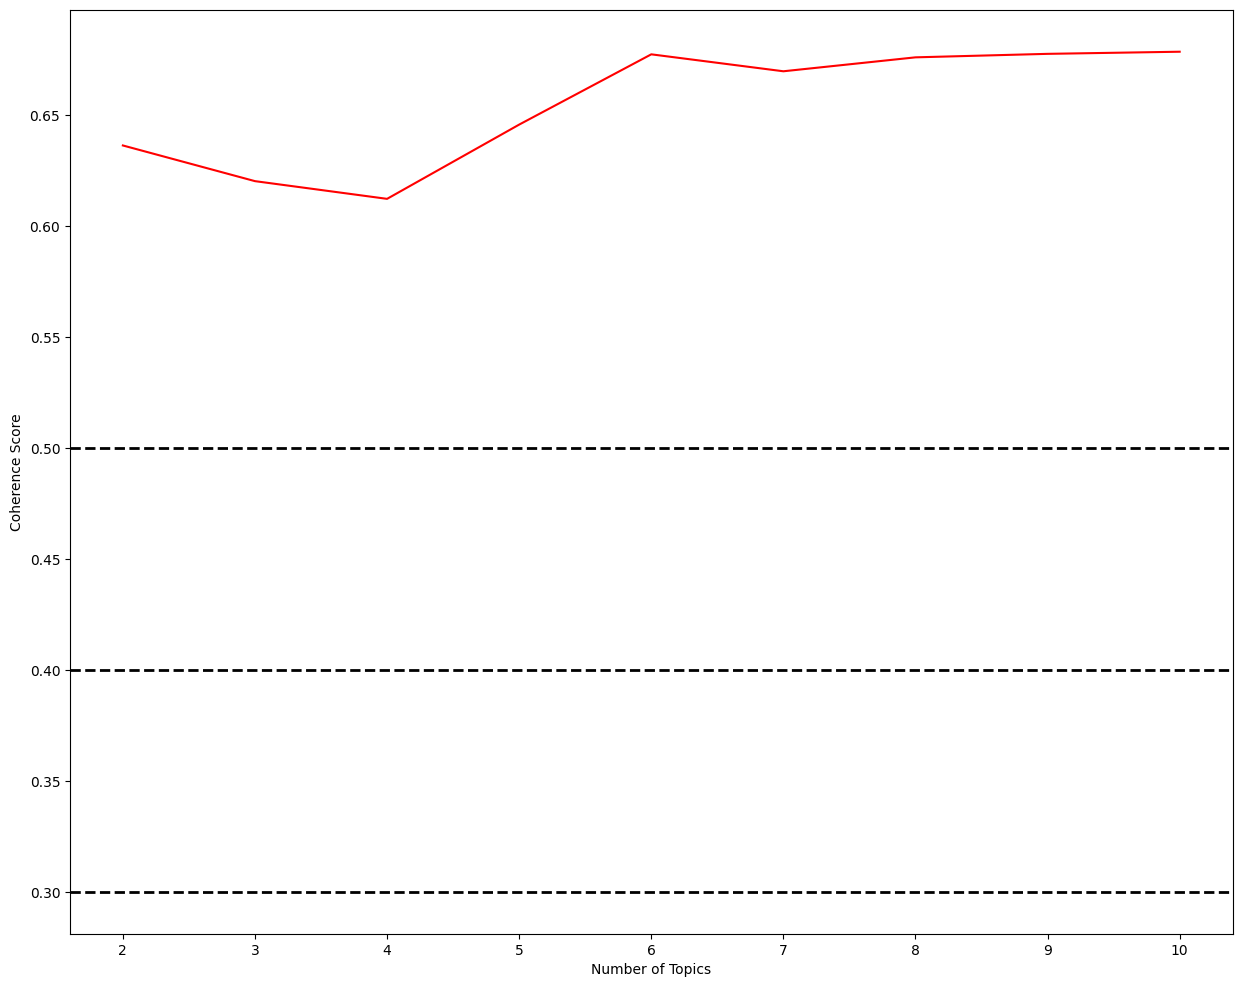

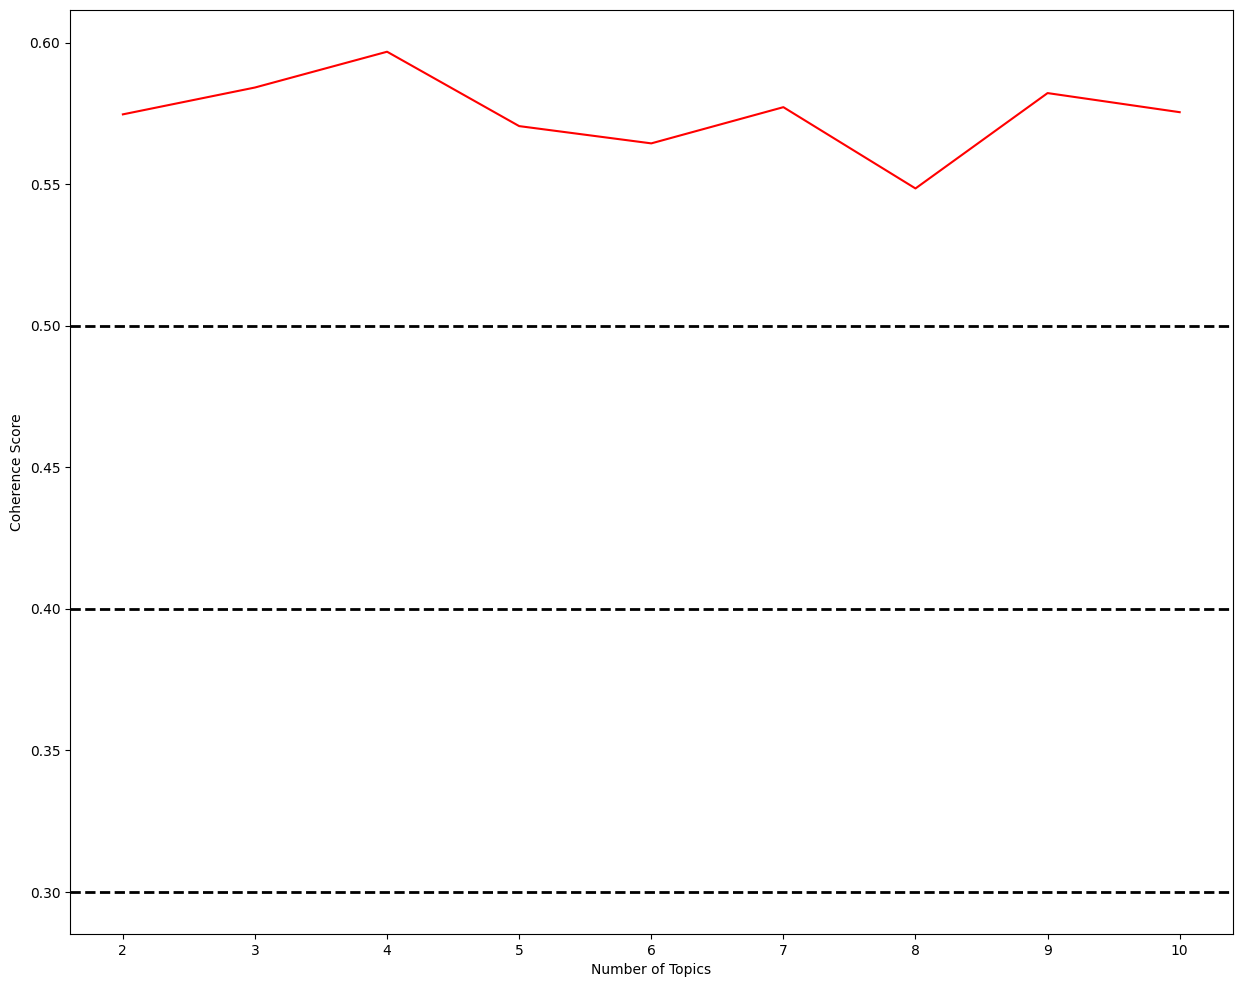


DF NAME: df_neg



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:44<05:53, 44.19s/it]

Topic #1:
0.326*"staff" + 0.299*"check" + 0.171*"book" + 0.170*"clean" + 0.161*"bed" + 0.156*"ask" + 0.154*"good" + 0.149*"bad" + 0.142*"even" + 0.137*"small" + 0.131*"come" + 0.125*"need" + 0.124*"like" + 0.124*"door" + 0.114*"breakfast" + 0.113*"water" + 0.112*"well" + 0.112*"towel" + 0.111*"give" + 0.111*"toilet"

Topic #2:
0.458*"check" + 0.322*"staff" + -0.273*"small" + -0.215*"bed" + -0.205*"toilet" + -0.198*"bathroom" + -0.192*"shower" + -0.177*"clean" + 0.168*"pm" + 0.163*"book" + -0.155*"smell" + -0.152*"good" + 0.151*"ask" + -0.129*"water" + 0.106*"wait" + 0.105*"tell" + 0.100*"arrive" + -0.083*"dirty" + -0.081*"old" + -0.077*"floor"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [01:28<05:11, 44.52s/it]

Topic #1:
0.327*"staff" + 0.300*"check" + 0.171*"book" + 0.169*"clean" + 0.161*"bed" + 0.156*"ask" + 0.154*"good" + 0.148*"bad" + 0.142*"even" + 0.137*"small" + 0.131*"come" + 0.125*"need" + 0.124*"like" + 0.123*"door" + 0.114*"breakfast" + 0.112*"towel" + 0.112*"water" + 0.112*"well" + 0.111*"give" + 0.111*"toilet"

Topic #2:
0.515*"check" + 0.271*"staff" + -0.244*"small" + -0.223*"clean" + -0.216*"bathroom" + -0.184*"shower" + 0.173*"pm" + -0.172*"bed" + -0.169*"toilet" + 0.168*"book" + -0.167*"smell" + -0.143*"water" + -0.134*"good" + 0.133*"ask" + -0.116*"dirty" + -0.101*"floor" + 0.094*"wait" + 0.091*"arrive" + 0.091*"pay" + 0.090*"tell"

Topic #3:
-0.628*"staff" + 0.453*"bed" + 0.284*"check" + 0.175*"book" + -0.170*"towel" + -0.139*"clean" + 0.134*"pm" + -0.119*"need" + -0.109*"well" + 0.089*"first" + -0.087*"friendly" + -0.086*"service" + -0.083*"good" + -0.080*"breakfast" + 0.076*"also" + 0.075*"bad" + 0.074*"store" + 0.073*"even" + 0.073*"toilet" + 0.072*"mention"

-----------

 33%|████████████████████████████                                                        | 3/9 [02:14<04:30, 45.06s/it]

Topic #1:
0.327*"staff" + 0.300*"check" + 0.171*"book" + 0.169*"clean" + 0.161*"bed" + 0.155*"ask" + 0.155*"good" + 0.148*"bad" + 0.142*"even" + 0.137*"small" + 0.131*"come" + 0.125*"need" + 0.124*"like" + 0.123*"door" + 0.114*"breakfast" + 0.112*"well" + 0.112*"water" + 0.112*"towel" + 0.111*"give" + 0.111*"toilet"

Topic #2:
0.422*"check" + 0.399*"staff" + -0.256*"bed" + -0.227*"small" + -0.221*"bathroom" + -0.204*"shower" + -0.202*"toilet" + -0.191*"clean" + -0.169*"smell" + 0.154*"book" + -0.146*"water" + 0.143*"pm" + -0.127*"dirty" + 0.119*"ask" + -0.114*"good" + -0.096*"floor" + 0.095*"tell" + -0.087*"bad" + 0.086*"pay" + 0.084*"wait"

Topic #3:
-0.564*"staff" + 0.431*"check" + 0.307*"bed" + -0.244*"breakfast" + 0.164*"pm" + -0.154*"clean" + -0.150*"well" + -0.145*"good" + 0.126*"ask" + -0.108*"small" + -0.102*"friendly" + 0.094*"first" + 0.091*"call" + 0.088*"toilet" + -0.086*"need" + 0.084*"wait" + 0.083*"door" + -0.078*"pool" + -0.071*"service" + 0.069*"also"

Topic #4:
0.357*

 44%|█████████████████████████████████████▎                                              | 4/9 [03:00<03:46, 45.30s/it]

Topic #1:
0.327*"staff" + 0.300*"check" + 0.171*"book" + 0.169*"clean" + 0.160*"bed" + 0.155*"ask" + 0.155*"good" + 0.148*"bad" + 0.143*"even" + 0.138*"small" + 0.131*"come" + 0.125*"need" + 0.124*"like" + 0.123*"door" + 0.114*"breakfast" + 0.112*"well" + 0.112*"water" + 0.111*"towel" + 0.111*"give" + 0.111*"toilet"

Topic #2:
-0.424*"staff" + -0.403*"check" + 0.285*"bed" + 0.230*"small" + 0.215*"bathroom" + 0.210*"toilet" + 0.207*"shower" + 0.176*"clean" + 0.164*"smell" + 0.143*"water" + -0.139*"book" + -0.133*"pm" + 0.122*"dirty" + -0.116*"ask" + 0.112*"good" + -0.096*"tell" + 0.091*"floor" + -0.086*"pay" + -0.081*"wait" + 0.081*"old"

Topic #3:
-0.550*"staff" + 0.451*"check" + 0.341*"bed" + -0.186*"clean" + -0.183*"breakfast" + 0.176*"pm" + -0.146*"well" + -0.136*"good" + 0.122*"ask" + 0.114*"book" + -0.098*"friendly" + 0.090*"first" + -0.089*"small" + 0.086*"toilet" + 0.085*"call" + 0.082*"wait" + -0.082*"need" + -0.076*"service" + 0.075*"arrive" + 0.072*"hour"

Topic #4:
0.361*"bo

 56%|██████████████████████████████████████████████▋                                     | 5/9 [03:46<03:02, 45.54s/it]

Topic #1:
0.328*"staff" + 0.300*"check" + 0.172*"book" + 0.169*"clean" + 0.160*"bed" + 0.155*"ask" + 0.155*"good" + 0.148*"bad" + 0.143*"even" + 0.138*"small" + 0.131*"come" + 0.125*"need" + 0.124*"like" + 0.123*"door" + 0.113*"breakfast" + 0.112*"well" + 0.112*"water" + 0.111*"give" + 0.111*"towel" + 0.111*"toilet"

Topic #2:
-0.432*"staff" + -0.398*"check" + 0.279*"bed" + 0.222*"small" + 0.215*"bathroom" + 0.207*"toilet" + 0.206*"shower" + 0.182*"clean" + 0.167*"smell" + -0.144*"book" + 0.142*"water" + -0.132*"pm" + 0.121*"dirty" + -0.116*"ask" + 0.111*"good" + -0.096*"tell" + 0.089*"floor" + -0.086*"pay" + 0.082*"bad" + 0.080*"old"

Topic #3:
-0.553*"staff" + 0.457*"check" + 0.324*"bed" + -0.207*"clean" + -0.177*"breakfast" + 0.174*"pm" + -0.146*"well" + -0.134*"good" + 0.122*"ask" + 0.105*"book" + -0.101*"friendly" + 0.089*"first" + -0.088*"need" + 0.087*"toilet" + 0.087*"call" + 0.084*"wait" + -0.081*"small" + -0.076*"service" + 0.075*"arrive" + 0.071*"hour"

Topic #4:
0.367*"book

 67%|████████████████████████████████████████████████████████                            | 6/9 [04:32<02:17, 45.87s/it]

Topic #1:
0.328*"staff" + 0.300*"check" + 0.171*"book" + 0.169*"clean" + 0.160*"bed" + 0.155*"good" + 0.155*"ask" + 0.148*"bad" + 0.143*"even" + 0.137*"small" + 0.131*"come" + 0.126*"need" + 0.123*"like" + 0.123*"door" + 0.113*"breakfast" + 0.113*"well" + 0.112*"water" + 0.112*"towel" + 0.111*"give" + 0.111*"toilet"

Topic #2:
-0.411*"staff" + -0.409*"check" + 0.273*"bed" + 0.219*"small" + 0.215*"bathroom" + 0.206*"shower" + 0.206*"toilet" + 0.199*"clean" + 0.167*"smell" + -0.159*"book" + 0.144*"water" + -0.136*"pm" + -0.122*"ask" + 0.121*"dirty" + 0.117*"good" + -0.096*"tell" + -0.090*"pay" + 0.089*"floor" + -0.081*"wait" + 0.080*"old"

Topic #3:
-0.580*"staff" + 0.411*"check" + 0.299*"bed" + -0.269*"clean" + 0.178*"book" + 0.153*"pm" + -0.144*"breakfast" + -0.131*"towel" + -0.131*"well" + -0.128*"good" + 0.125*"ask" + -0.105*"need" + -0.101*"friendly" + 0.093*"first" + -0.088*"service" + 0.086*"toilet" + 0.076*"even" + 0.075*"call" + 0.070*"wait" + 0.070*"hour"

Topic #4:
0.351*"book

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [05:21<01:33, 46.82s/it]

Topic #1:
0.328*"staff" + 0.300*"check" + 0.171*"book" + 0.170*"clean" + 0.161*"bed" + 0.155*"good" + 0.155*"ask" + 0.147*"bad" + 0.143*"even" + 0.136*"small" + 0.131*"come" + 0.126*"need" + 0.123*"like" + 0.123*"door" + 0.114*"breakfast" + 0.112*"well" + 0.112*"towel" + 0.112*"water" + 0.111*"give" + 0.111*"toilet"

Topic #2:
0.429*"check" + 0.389*"staff" + -0.264*"small" + -0.232*"bed" + -0.210*"bathroom" + -0.203*"shower" + -0.200*"toilet" + -0.186*"clean" + -0.164*"smell" + 0.161*"book" + -0.154*"water" + 0.142*"pm" + 0.130*"ask" + -0.126*"good" + -0.113*"dirty" + 0.096*"tell" + 0.085*"pay" + -0.084*"floor" + 0.082*"wait" + 0.080*"arrive"

Topic #3:
-0.594*"staff" + 0.395*"check" + 0.335*"bed" + -0.237*"clean" + 0.163*"book" + 0.148*"pm" + -0.140*"breakfast" + -0.135*"well" + -0.127*"good" + -0.127*"towel" + 0.121*"ask" + -0.103*"need" + -0.101*"friendly" + 0.096*"first" + 0.095*"toilet" + -0.089*"service" + 0.075*"call" + 0.072*"even" + 0.066*"wait" + 0.065*"hour"

Topic #4:
0.354

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [06:17<00:49, 49.57s/it]

Topic #1:
0.328*"staff" + 0.300*"check" + 0.171*"book" + 0.170*"clean" + 0.161*"bed" + 0.155*"good" + 0.155*"ask" + 0.147*"bad" + 0.143*"even" + 0.136*"small" + 0.131*"come" + 0.126*"need" + 0.124*"like" + 0.123*"door" + 0.114*"breakfast" + 0.113*"well" + 0.112*"towel" + 0.112*"water" + 0.111*"give" + 0.111*"toilet"

Topic #2:
0.431*"check" + 0.388*"staff" + -0.263*"small" + -0.232*"bed" + -0.211*"bathroom" + -0.204*"shower" + -0.201*"toilet" + -0.186*"clean" + 0.167*"book" + -0.159*"smell" + -0.154*"water" + 0.144*"pm" + 0.128*"ask" + -0.120*"good" + -0.116*"dirty" + 0.096*"tell" + -0.087*"floor" + 0.085*"pay" + 0.082*"wait" + 0.080*"arrive"

Topic #3:
-0.589*"staff" + 0.403*"check" + 0.333*"bed" + -0.232*"clean" + 0.163*"book" + 0.150*"pm" + -0.149*"breakfast" + -0.135*"well" + -0.130*"towel" + -0.123*"good" + 0.110*"ask" + -0.105*"need" + 0.100*"toilet" + -0.099*"friendly" + 0.091*"first" + -0.089*"service" + 0.080*"even" + 0.074*"call" + 0.069*"bad" + 0.066*"hour"

Topic #4:
0.360*

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [07:06<00:00, 47.40s/it]


Topic #1:
0.328*"staff" + 0.300*"check" + 0.171*"book" + 0.170*"clean" + 0.161*"bed" + 0.155*"ask" + 0.155*"good" + 0.148*"bad" + 0.143*"even" + 0.136*"small" + 0.131*"come" + 0.125*"need" + 0.123*"like" + 0.123*"door" + 0.114*"breakfast" + 0.113*"well" + 0.112*"towel" + 0.111*"water" + 0.111*"give" + 0.111*"toilet"

Topic #2:
0.426*"check" + 0.391*"staff" + -0.265*"small" + -0.234*"bed" + -0.211*"bathroom" + -0.205*"shower" + -0.202*"toilet" + -0.186*"clean" + 0.169*"book" + -0.158*"smell" + -0.157*"water" + 0.140*"pm" + 0.131*"ask" + -0.124*"good" + -0.114*"dirty" + 0.096*"tell" + -0.087*"floor" + 0.085*"pay" + 0.082*"wait" + 0.079*"arrive"

Topic #3:
-0.580*"staff" + 0.402*"check" + 0.341*"bed" + -0.221*"clean" + 0.168*"book" + -0.149*"breakfast" + 0.149*"pm" + -0.138*"well" + -0.131*"towel" + -0.130*"good" + 0.109*"ask" + -0.107*"need" + 0.105*"toilet" + -0.098*"friendly" + 0.091*"first" + -0.088*"service" + 0.085*"bad" + 0.084*"even" + 0.074*"call" + 0.064*"hour"

Topic #4:
0.365*

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:04<00:39,  4.88s/it]

Topic #1:
0.025*"small" + 0.015*"staff" + 0.014*"water" + 0.013*"clean" + 0.012*"like" + 0.012*"dirty" + 0.012*"bad" + 0.011*"bathroom" + 0.011*"floor" + 0.011*"towel" + 0.010*"shower" + 0.009*"bed" + 0.009*"check" + 0.009*"bit" + 0.009*"experience" + 0.009*"door" + 0.008*"book" + 0.008*"take" + 0.008*"old" + 0.008*"need"

Topic #2:
0.019*"staff" + 0.017*"good" + 0.016*"check" + 0.014*"breakfast" + 0.014*"clean" + 0.012*"bed" + 0.012*"smell" + 0.011*"book" + 0.011*"well" + 0.011*"bad" + 0.010*"like" + 0.010*"need" + 0.009*"service" + 0.009*"nothing" + 0.009*"pool" + 0.009*"even" + 0.009*"ask" + 0.009*"small" + 0.008*"toilet" + 0.007*"also"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:09<00:33,  4.72s/it]

Topic #1:
0.016*"water" + 0.016*"bathroom" + 0.014*"bed" + 0.012*"good" + 0.011*"price" + 0.010*"even" + 0.010*"shower" + 0.010*"need" + 0.010*"smell" + 0.010*"door" + 0.009*"clean" + 0.009*"old" + 0.009*"bit" + 0.009*"little" + 0.008*"like" + 0.008*"well" + 0.008*"look" + 0.008*"give" + 0.008*"book" + 0.008*"dirty"

Topic #2:
0.023*"staff" + 0.019*"check" + 0.019*"clean" + 0.019*"bad" + 0.017*"breakfast" + 0.017*"good" + 0.016*"nothing" + 0.013*"like" + 0.012*"ask" + 0.011*"smell" + 0.011*"book" + 0.010*"well" + 0.010*"bed" + 0.010*"make" + 0.009*"could" + 0.009*"pool" + 0.009*"experience" + 0.008*"also" + 0.008*"come" + 0.008*"small"

Topic #3:
0.033*"small" + 0.022*"staff" + 0.015*"toilet" + 0.014*"need" + 0.013*"check" + 0.011*"clean" + 0.011*"like" + 0.011*"book" + 0.010*"bit" + 0.010*"take" + 0.009*"service" + 0.009*"good" + 0.009*"old" + 0.009*"also" + 0.009*"breakfast" + 0.009*"work" + 0.008*"well" + 0.008*"dirty" + 0.008*"bed" + 0.008*"come"

----------------------------------

 33%|████████████████████████████                                                        | 3/9 [00:13<00:26,  4.43s/it]

Topic #1:
0.026*"check" + 0.021*"staff" + 0.019*"book" + 0.017*"breakfast" + 0.015*"clean" + 0.012*"bad" + 0.012*"experience" + 0.012*"pay" + 0.011*"recommend" + 0.010*"well" + 0.010*"towel" + 0.010*"service" + 0.010*"pm" + 0.010*"need" + 0.010*"reception" + 0.010*"make" + 0.009*"even" + 0.009*"like" + 0.009*"give" + 0.009*"feel"

Topic #2:
0.023*"staff" + 0.019*"good" + 0.019*"nothing" + 0.018*"breakfast" + 0.016*"small" + 0.015*"bathroom" + 0.014*"clean" + 0.013*"work" + 0.012*"like" + 0.012*"smell" + 0.010*"little" + 0.010*"old" + 0.009*"bit" + 0.009*"could" + 0.009*"look" + 0.009*"service" + 0.009*"bed" + 0.009*"need" + 0.009*"door" + 0.009*"long"

Topic #3:
0.022*"dirty" + 0.018*"bed" + 0.016*"clean" + 0.016*"like" + 0.015*"toilet" + 0.015*"pool" + 0.014*"staff" + 0.013*"well" + 0.013*"quite" + 0.013*"need" + 0.012*"good" + 0.012*"also" + 0.012*"floor" + 0.011*"small" + 0.010*"book" + 0.010*"bad" + 0.010*"take" + 0.009*"even" + 0.009*"nice" + 0.008*"water"

Topic #4:
0.028*"small"

 44%|█████████████████████████████████████▎                                              | 4/9 [00:17<00:21,  4.28s/it]

Topic #1:
0.028*"check" + 0.027*"staff" + 0.017*"book" + 0.016*"smell" + 0.013*"door" + 0.012*"bed" + 0.012*"ask" + 0.012*"like" + 0.011*"give" + 0.010*"breakfast" + 0.009*"floor" + 0.009*"toilet" + 0.009*"well" + 0.008*"could" + 0.008*"good" + 0.008*"pm" + 0.008*"bathroom" + 0.008*"bad" + 0.008*"pay" + 0.008*"come"

Topic #2:
0.043*"nothing" + 0.043*"breakfast" + 0.025*"small" + 0.018*"price" + 0.015*"pool" + 0.014*"bit" + 0.014*"service" + 0.014*"well" + 0.013*"good" + 0.013*"clean" + 0.012*"buffet" + 0.010*"little" + 0.010*"use" + 0.009*"book" + 0.009*"expect" + 0.009*"recommend" + 0.008*"staff" + 0.008*"great" + 0.008*"expensive" + 0.008*"much"

Topic #3:
0.036*"bad" + 0.023*"good" + 0.023*"water" + 0.018*"dirty" + 0.016*"staff" + 0.013*"experience" + 0.013*"like" + 0.013*"smell" + 0.012*"need" + 0.012*"clean" + 0.012*"towel" + 0.012*"shower" + 0.011*"even" + 0.011*"check" + 0.010*"well" + 0.009*"give" + 0.009*"toilet" + 0.009*"small" + 0.008*"service" + 0.008*"also"

Topic #4:
0.0

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:21<00:16,  4.20s/it]

Topic #1:
0.038*"good" + 0.022*"breakfast" + 0.016*"small" + 0.015*"pool" + 0.015*"water" + 0.014*"guest" + 0.013*"toilet" + 0.013*"feel" + 0.012*"check" + 0.012*"area" + 0.011*"view" + 0.010*"air_condition" + 0.010*"make" + 0.009*"staff" + 0.009*"bad" + 0.009*"price" + 0.008*"cold" + 0.008*"food" + 0.008*"door" + 0.008*"also"

Topic #2:
0.027*"small" + 0.024*"smell" + 0.020*"staff" + 0.017*"clean" + 0.016*"need" + 0.014*"check" + 0.014*"bathroom" + 0.013*"bit" + 0.013*"bed" + 0.012*"even" + 0.010*"toilet" + 0.010*"recommend" + 0.010*"floor" + 0.010*"make" + 0.010*"people" + 0.009*"take" + 0.008*"sleep" + 0.008*"good" + 0.008*"shower" + 0.008*"book"

Topic #3:
0.061*"nothing" + 0.022*"breakfast" + 0.021*"like" + 0.021*"small" + 0.018*"shower" + 0.015*"pay" + 0.015*"everything" + 0.014*"water" + 0.013*"work" + 0.012*"could" + 0.012*"come" + 0.010*"check" + 0.009*"staff" + 0.009*"bed" + 0.009*"first" + 0.009*"price" + 0.009*"take" + 0.009*"ac" + 0.008*"morning" + 0.008*"bad"

Topic #4:
0

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:25<00:12,  4.16s/it]

Topic #1:
0.035*"like" + 0.019*"book" + 0.017*"god" + 0.017*"feel" + 0.016*"bed" + 0.015*"never" + 0.013*"pool" + 0.013*"guest" + 0.013*"key" + 0.013*"expensive" + 0.012*"wall" + 0.012*"meet" + 0.012*"seem" + 0.012*"even" + 0.012*"ask" + 0.011*"near" + 0.011*"old" + 0.010*"cold" + 0.009*"staff" + 0.009*"disappointing"

Topic #2:
0.028*"clean" + 0.022*"smell" + 0.021*"well" + 0.017*"staff" + 0.016*"water" + 0.015*"need" + 0.013*"service" + 0.013*"bathroom" + 0.013*"good" + 0.012*"shower" + 0.012*"pool" + 0.011*"guest" + 0.011*"toilet" + 0.011*"also" + 0.010*"work" + 0.010*"even" + 0.010*"towel" + 0.009*"quite" + 0.009*"bad" + 0.009*"come"

Topic #3:
0.034*"good" + 0.029*"bad" + 0.017*"dirty" + 0.015*"door" + 0.013*"sleep" + 0.013*"clean" + 0.013*"open" + 0.012*"area" + 0.012*"bathroom" + 0.011*"luggage" + 0.010*"could" + 0.010*"floor" + 0.010*"water" + 0.010*"take" + 0.010*"people" + 0.009*"use" + 0.009*"smell" + 0.009*"breakfast" + 0.009*"even" + 0.009*"experience"

Topic #4:
0.036*"sm

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:29<00:08,  4.10s/it]

Topic #1:
0.034*"like" + 0.019*"small" + 0.015*"bit" + 0.015*"price" + 0.014*"well" + 0.014*"little" + 0.013*"bathroom" + 0.011*"say" + 0.011*"look" + 0.011*"really" + 0.010*"even" + 0.010*"much" + 0.010*"bed" + 0.010*"feel" + 0.010*"give" + 0.010*"book" + 0.009*"leave" + 0.009*"meet" + 0.009*"ask" + 0.009*"seem"

Topic #2:
0.039*"bad" + 0.027*"good" + 0.023*"staff" + 0.019*"check" + 0.016*"book" + 0.013*"experience" + 0.013*"give" + 0.013*"even" + 0.013*"door" + 0.011*"toilet" + 0.011*"service" + 0.011*"come" + 0.010*"small" + 0.009*"dirty" + 0.009*"like" + 0.009*"look" + 0.008*"smell" + 0.008*"breakfast" + 0.008*"pay" + 0.008*"thing"

Topic #3:
0.016*"breakfast" + 0.016*"bed" + 0.015*"water" + 0.014*"good" + 0.013*"shower" + 0.013*"toilet" + 0.013*"area" + 0.013*"use" + 0.012*"dirty" + 0.012*"expensive" + 0.012*"facility" + 0.012*"quite" + 0.011*"smoke" + 0.011*"price" + 0.011*"charge" + 0.010*"hostel" + 0.010*"bathroom" + 0.010*"people" + 0.010*"old" + 0.010*"door"

Topic #4:
0.042*

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:33<00:04,  4.06s/it]

Topic #1:
0.041*"nothing" + 0.026*"good" + 0.025*"staff" + 0.024*"ask" + 0.023*"well" + 0.019*"breakfast" + 0.015*"bad" + 0.013*"could" + 0.012*"great" + 0.011*"thing" + 0.011*"say" + 0.011*"come" + 0.011*"everything" + 0.011*"clean" + 0.010*"god" + 0.009*"star" + 0.009*"experience" + 0.009*"food" + 0.009*"dirty" + 0.009*"recommend"

Topic #2:
0.021*"door" + 0.019*"staff" + 0.016*"check" + 0.016*"bed" + 0.015*"open" + 0.012*"small" + 0.012*"toilet" + 0.012*"could" + 0.012*"keep" + 0.010*"little" + 0.010*"quite" + 0.009*"bad" + 0.009*"next" + 0.009*"shower" + 0.009*"guest" + 0.009*"even" + 0.009*"take" + 0.008*"space" + 0.008*"first" + 0.008*"work"

Topic #3:
0.026*"check" + 0.022*"like" + 0.021*"price" + 0.019*"small" + 0.018*"good" + 0.018*"bad" + 0.016*"book" + 0.013*"look" + 0.013*"clean" + 0.012*"really" + 0.012*"old" + 0.011*"take" + 0.011*"well" + 0.010*"staff" + 0.009*"long" + 0.009*"want" + 0.009*"hour" + 0.009*"need" + 0.009*"guest" + 0.008*"pay"

Topic #4:
0.022*"good" + 0.02

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:37<00:00,  4.18s/it]

Topic #1:
0.032*"clean" + 0.021*"dirty" + 0.020*"water" + 0.015*"good" + 0.015*"change" + 0.012*"like" + 0.012*"bed" + 0.012*"bathroom" + 0.011*"check" + 0.011*"small" + 0.011*"hear" + 0.010*"toilet" + 0.010*"staff" + 0.010*"ask" + 0.009*"could" + 0.009*"make" + 0.009*"work" + 0.009*"towel" + 0.009*"say" + 0.009*"never"

Topic #2:
0.030*"breakfast" + 0.022*"nothing" + 0.021*"bed" + 0.016*"lot" + 0.015*"well" + 0.015*"buffet" + 0.015*"u" + 0.015*"toilet" + 0.015*"small" + 0.014*"bit" + 0.012*"always" + 0.012*"old" + 0.012*"expensive" + 0.011*"book" + 0.011*"coffee" + 0.011*"size" + 0.010*"tiny" + 0.010*"staff" + 0.009*"clean" + 0.009*"door"

Topic #3:
0.049*"small" + 0.030*"staff" + 0.018*"clean" + 0.018*"towel" + 0.017*"food" + 0.016*"book" + 0.015*"good" + 0.014*"breakfast" + 0.014*"bed" + 0.013*"need" + 0.012*"well" + 0.011*"check" + 0.010*"even" + 0.010*"poor" + 0.010*"area" + 0.010*"service" + 0.009*"bad" + 0.009*"toilet" + 0.009*"bit" + 0.009*"know"

Topic #4:
0.039*"check" + 0.02

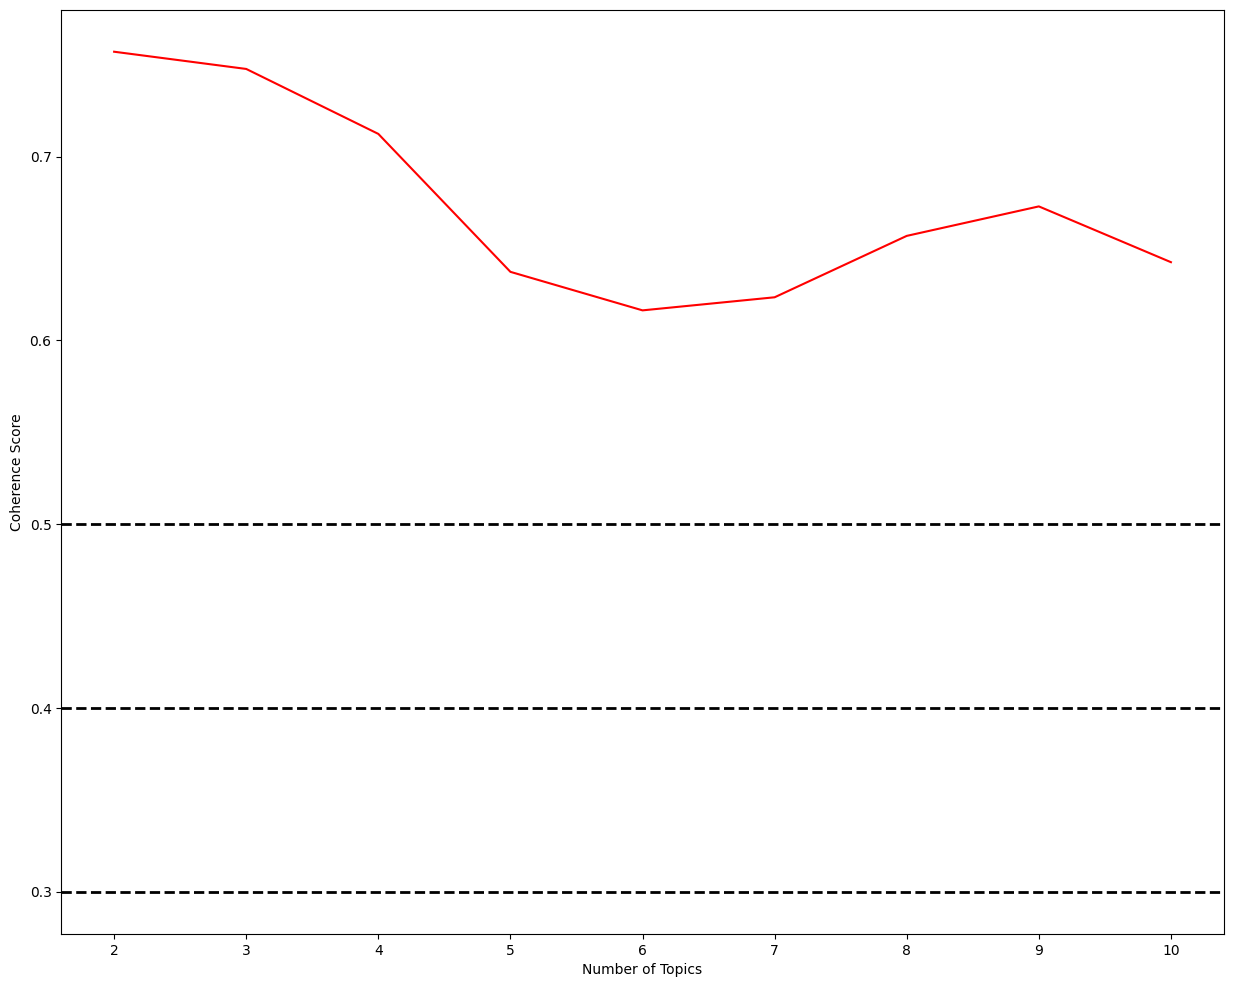

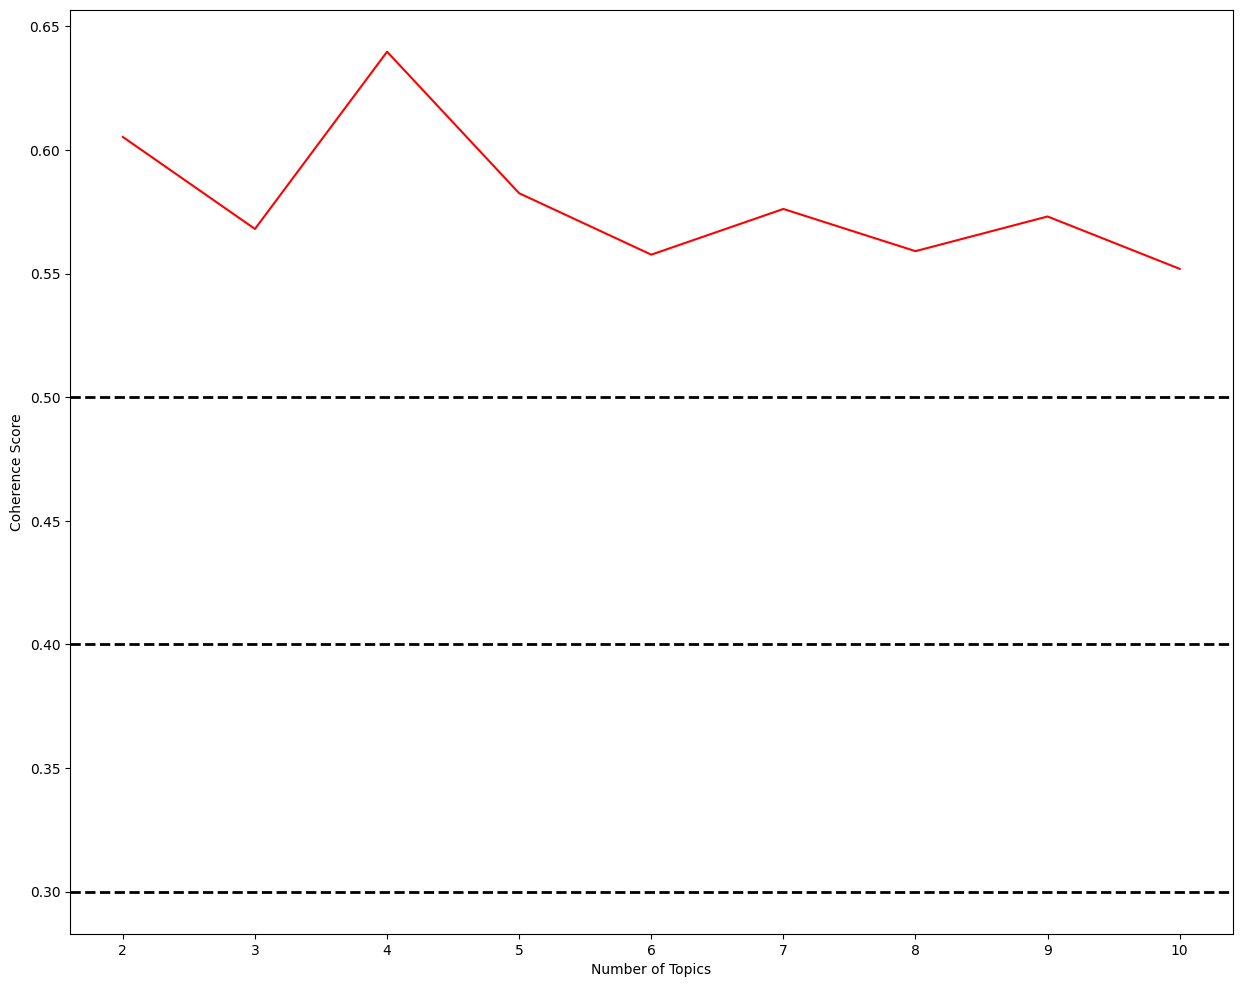

In [10]:
# Calculate coherence scores for each model
target_text = "review_cleaned_v2"

overall_coherence_df = pd.DataFrame() # df to store coherence_df
model_topic_info_list = []  # List to store model_topic_info

for i, df_set in enumerate(df_sets):
    
    print("\nDF NAME: {}\n".format(df_names[i]))

    coherence_df, model_topic_info = topic_model_coherence_plot(df_set, df_names[i], target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT)
    overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0) # Concatenate to overall_coherence_df
    model_topic_info_list.append(model_topic_info) # Store model_topic_info in a list

In [11]:
# Print all models' coherence scores
overall_coherence_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.636168,df_pos
1,LSI,3,0.620094,df_pos
2,LSI,4,0.612117,df_pos
3,LSI,5,0.645568,df_pos
4,LSI,6,0.677220,df_pos
5,LSI,7,0.669586,df_pos
6,LSI,8,0.675862,df_pos
7,LSI,9,0.677436,df_pos
8,LSI,10,0.678394,df_pos
0,LDA,2,0.574655,df_pos


In [12]:
# Store coherence scores of all models into "overall_coherence_df", sort by "df_name" and "Coherence Score"
overall_coherence_df = overall_coherence_df.sort_values(["df_name", "Coherence Score"], ascending=False).reset_index(drop=True)
#overall_coherence_df

# Find best model for each df
overall_coherence_best_df = overall_coherence_df.loc[overall_coherence_df.groupby("df_name")["Coherence Score"].idxmax()].reset_index(drop=True)
overall_coherence_best_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.757056,df_neg
1,LSI,10,0.678394,df_pos


In [13]:
# Print topics of best model
print_best_model_topics(overall_coherence_best_df, model_topic_info_list)


DF NAME: df_neg
MODEL: LSI - NUMBER OF TOPICS: 2

Topic 1: staff, check, book, clean, bed, ask, good, bad, even, small

Topic 2: check, staff, small, bed, toilet, bathroom, shower, clean, pm, book

----------


DF NAME: df_pos
MODEL: LSI - NUMBER OF TOPICS: 10

Topic 1: good, staff, clean, great, also, check, nice, friendly, small, bed

Topic 2: good, staff, great, check, friendly, also, clean, helpful, nice, book

Topic 3: staff, friendly, helpful, also, bed, check, good, small, book, need

Topic 4: clean, check, staff, near, book, meet, good, nice, ask, tell

Topic 5: great, clean, check, meet, staff, near, restaurant, pool, area, food

Topic 6: great, check, clean, small, nice, near, staff, service, meet, good

Topic 7: nice, bed, near, check, small, also, shower, meet, toilet, bathroom

Topic 8: nice, near, bed, meet, small, breakfast, great, also, food, pool

Topic 9: small, check, also, shower, near, meet, bed, service, book, door

Topic 10: also, breakfast, small, bed, say, mee

In [14]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-26 23:40:54.407692
Text processing spent 0:36:12.151166
